In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import utils

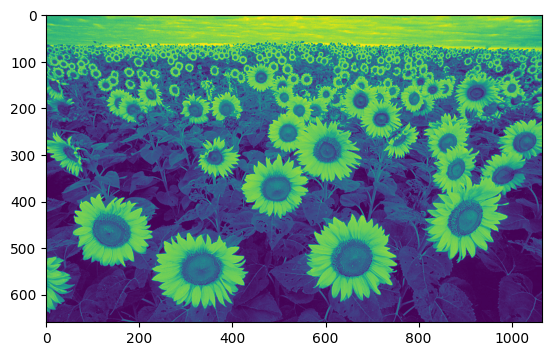

In [2]:
im_og = cv2.imread("sunflowers.jpg", cv2.IMREAD_GRAYSCALE)
im = im_og.astype(float)/255
plt.imshow(im)

In [3]:
def scaleSpaced(im, sigma, n):
    im_scales = []
    for i in range(n):
        size = 5
        curr_sigma = sigma * (2**i)
        x = np.arange(-size*curr_sigma, size*curr_sigma+1)
        gaus = utils.gaussian(x,curr_sigma)
        gaus = np.array([gaus / gaus.sum()])
        im_scales.append(cv2.sepFilter2D(im, -1, gaus, gaus))
    return im_scales

def differenceOfGaussians(im, sigma, n):
    DoG = []
    im_scales = scaleSpaced(im, sigma, n+1)
    for i in range(n):
        DoG.append(im_scales[i+1] - im_scales[i])
    return DoG

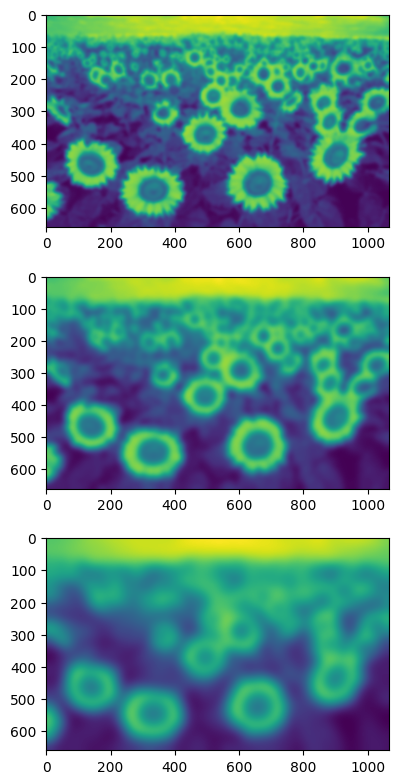

In [4]:
n = 3 # num of gaussians
ims = scaleSpaced(im, 5, n)

fig, axs = plt.subplots(n, 1, figsize=(4, 8))
for i in range(n):
    axs[i].imshow(ims[i])
plt.tight_layout()
plt.show()

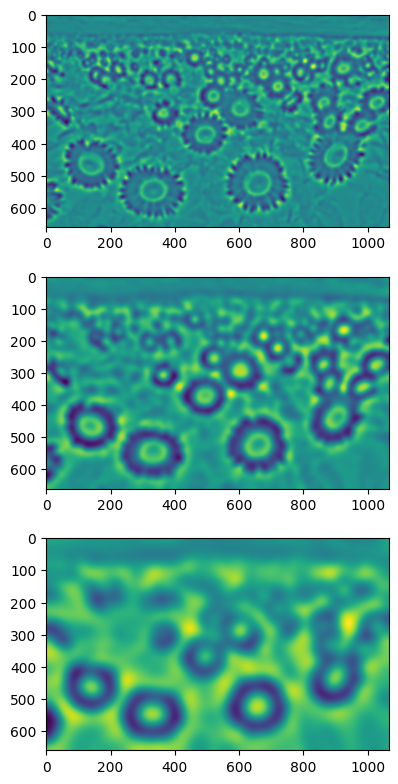

In [5]:
n = 3 # num of DoGs
DoG = differenceOfGaussians(im, 5, n)

fig, axs = plt.subplots(n, 1, figsize=(4, 8))
for i in range(n):
    axs[i].imshow(DoG[i])
plt.tight_layout()
plt.show()

In [6]:
def detectBlobs(im, sigma, n, tau):
    DoG = differenceOfGaussians(im, sigma, n)
    MaxDoG = []
    pixels = []
    scales = []
    for i in range(n):
        MaxDoG.append(cv2.dilate(abs(DoG[i]), np.ones((3,3))))
    for k in range(n):
        for (i, j), _ in np.ndenumerate(im):
            if DoG[k][i,j] > tau:
                if k == 0:
                    if DoG[k][i,j] > MaxDoG[k+1][i,j] and DoG[k][i,j] == MaxDoG[k][i,j]:
                        pixels.append((i, j))
                        scales.append(k)
                elif k == n-1:
                    if DoG[k][i,j] > MaxDoG[k-1][i,j] and DoG[k][i,j] == MaxDoG[k][i,j]:
                        pixels.append((i, j))
                        scales.append(k)
                elif DoG[k][i,j] > MaxDoG[k+1][i,j] and DoG[k][i,j] > MaxDoG[k-1][i,j]:
                    if DoG[k][i,j] == MaxDoG[k][i,j]:
                        pixels.append((i, j))
                        scales.append(k)
    return pixels, scales


In [7]:
sigma = 2
n = 7
tau = 0.1
blobs, scales = detectBlobs(im, sigma, n, tau)

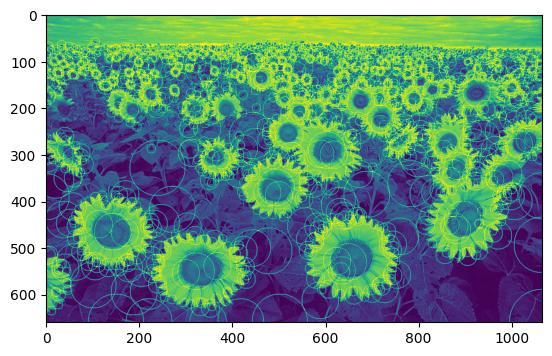

In [8]:
color = (1, 0, 0)
im_cpy = im.copy()
for i in range(len(blobs)):
    im_cpy = cv2.circle(im_cpy, (blobs[i][1], blobs[i][0]), (scales[i]+1) * 10, color, 1) 
plt.imshow(im_cpy)

In [30]:
def transformIm(im, theta, s):
    h, w = im.shape[:2]
    center = (w / 2, h / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, theta, 1)
    rotated_im = cv2.warpAffine(im, rotation_matrix, (w, h))
    scaling_matrix = np.array([[s, 0, (1 - s) * w / 2], [0, s, (1 - s) * h / 2]], dtype=np.float32)
    scaled_im = cv2.warpAffine(rotated_im, scaling_matrix, (w, h))
    #return cv2.cvtColor(scaled_im, cv2.COLOR_BGR2GRAY)
    return (scaled_im*255).astype('uint8')

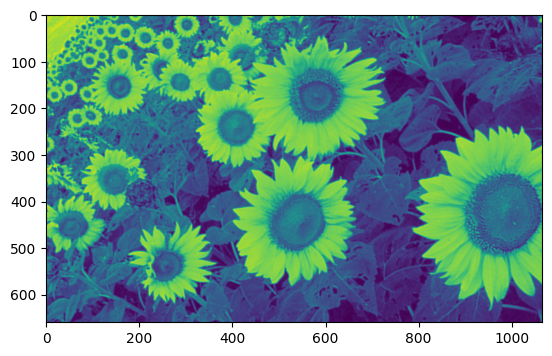

In [31]:
tf_im = transformIm(im, 45, 2)
plt.imshow(tf_im)

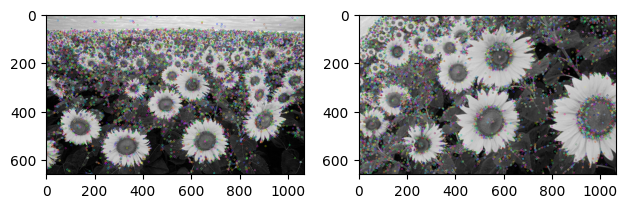

In [42]:
sift = cv2.SIFT.create()
kp1, des1 = sift.detectAndCompute(im_og, None)
kp2, des2 = sift.detectAndCompute(tf_im, None)
im1_kps = cv2.drawKeypoints(im_og, kp1, None)
im2_kps = cv2.drawKeypoints(tf_im, kp2, None)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(im1_kps)
axs[1].imshow(im2_kps)
plt.tight_layout()
plt.show()

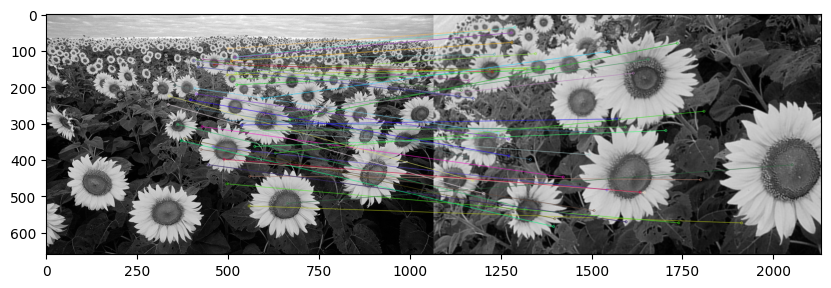

In [41]:
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
sorted_matches = sorted(matches, key = lambda x:x.distance)

mimg = cv2.drawMatches(im_og, kp1, tf_im, kp2, sorted_matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg)

Ratio test

An alternative to cross checking

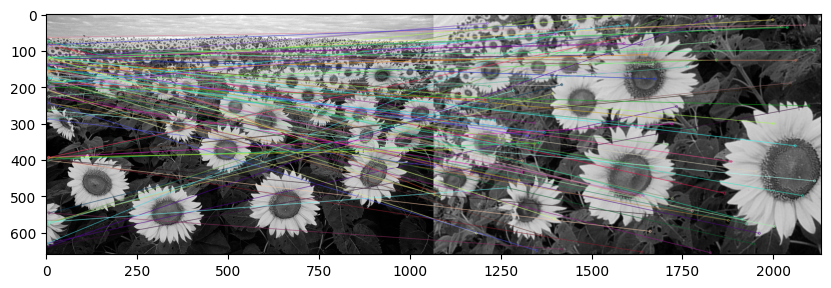

In [44]:
bf2 = cv2.BFMatcher()
matches_2 = bf2.knnMatch(des1,des2,k=2)

mimg_2 = cv2.drawMatchesKnn(im_og, kp1, tf_im, kp2, matches_2[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg_2)

In [45]:
good = []
for m,n in matches_2: # Each matches[i] is k or less matches for the same query descriptor.
    if m.distance < 0.75*n.distance:
        good.append([m])
print("Distinctive matches:", len(good))

Distinctive matches: 1184


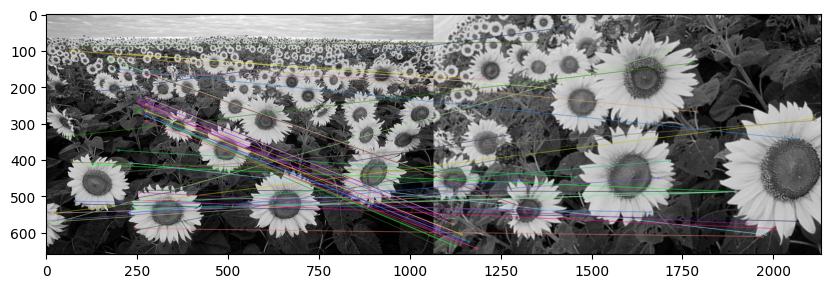

In [46]:
mimg_3 = cv2.drawMatchesKnn(im_og, kp1, tf_im, kp2, good[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (10,10))
plt.imshow(mimg_3)